# Multi Armed Bandit Playground

In [260]:
import numpy as np
import pandas as pd

from scipy.stats import bernoulli
from scipy.stats import norm

# from tqdm.notebook import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm

## Slot Machine Simulator

Reward types:

* bernoulli
  - Binary (**0** or **1**) reward with a given probability *p*
* norm
  - Continuos reward given by a normal distribution defined by *μ* and *σ*


In [112]:
class SlotMachine(object):
    
    reward_type_list = ['bernoulli', 'norm']

    def __init__(self, lever_reward_list, reward_type = 'bernoulli', seed = None):
        
        if reward_type not in SlotMachine.reward_type_list:
            raise ValueError("Reward Type unknown")
        
        self.lever_reward_list = lever_reward_list
        self.reward_type = reward_type
        np.random.seed(seed)

    def pull_lever(self, lever_idx):
        if self.reward_type == 'bernoulli':
            return bernoulli.rvs(self.lever_reward_list[lever_idx], size=1)[0]
        elif self.reward_type == 'norm':
            return norm.rvs(loc=self.lever_reward_list[lever_idx][0],scale=self.lever_reward_list[lever_idx][1],size=1)[0]       
    @property
    def n_levers(self):
        return len(self.lever_reward_list)

### Some simulations

In [113]:
def simulate_pull_lever(N, reward_list, reward_type):
    N = 1000
    slot_machine = SlotMachine(reward_list, reward_type=reward_type)
    lever_reward_mean = {}

    fig = plt.figure(figsize=(10,5))
    for i, prob in enumerate(range(slot_machine.n_levers)):
        lever_reward_mean[prob] = np.mean([slot_machine.pull_lever(i) for _ in range(N)])

    p = sns.barplot(
        x=list(range(len(reward_list))),
        y=list(lever_reward_mean.values())
        )
    p.set(xticklabels=[f"Lever {i}" for i in list(range(len(reward_list)))])
    p.set(xlabel = 'Lever', ylabel = 'Expected Reward', title=f"Expected reward for each lever. Reward type: '{reward_type}'")

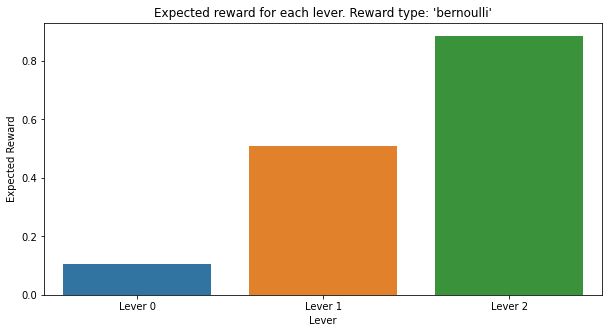

In [114]:
simulate_pull_lever(1000,[0.1, 0.5, 0.9], 'bernoulli')

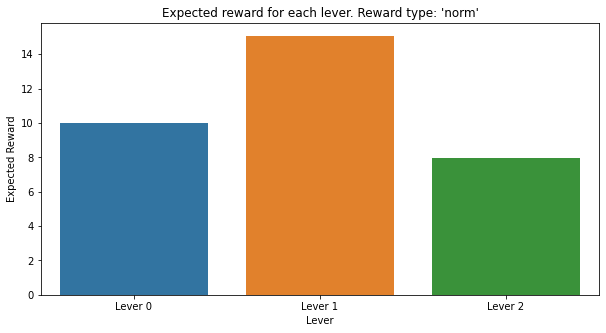

In [88]:
simulate_pull_lever(1000, [(10,1),(15,3),(8,2)], 'norm')

## Multi Armed Bandit agent

In [303]:
class MAB(object):

    estimation_policy_list = ['avg', 'ema']

    def __init__(self, n_levers, epsilon=0.2, estimation_policy='avg'):
        self.lever_expected_reward = {i:0 for i in range(n_levers)}
        self.lever_n_observations = {i:0 for i in range(n_levers)}
        self.lever_sequence = []
        self.estimation_policy = estimation_policy
        self.overall_expected_reward = 0
        self.overall_expected_reward_list = []
        self.n_levers = n_levers
        self.levers = list(range(n_levers))
        self.epsilon = epsilon

    def avg(self, reward, expected_reward, n_obs):
        return reward/n_obs + ((n_obs-1)/n_obs)*expected_reward

    def update_reward_expectation(self, reward, lever_idx):
        
        self.lever_n_observations[lever_idx] +=1
        self.lever_sequence.append(lever_idx)
        
        # Update reward expectation for a given lever
        if self.lever_n_observations[lever_idx] == 1:
            self.lever_expected_reward[lever_idx] = reward
        else:
            if self.estimation_policy == 'avg':
                self.lever_expected_reward[lever_idx] = self.avg(
                    reward, 
                    self.lever_expected_reward[lever_idx], 
                    self.lever_n_observations[lever_idx])
        
        # Update MAB overall expected reward
        self.overall_expected_reward = self.avg(
            reward,
            self.overall_expected_reward,
            np.sum(np.array(list(self.lever_n_observations.values()))))
        
        self.overall_expected_reward_list.append(self.overall_expected_reward)
    
    def choose_lever(self):        
        
        if not all(list(self.lever_n_observations.values())):
            return np.random.choice(self.levers,size=1)[0]
        else:
            # Choose between exploration and exploitation
            p = np.random.rand(1)[0]
            
            if p < self.epsilon: # exploration
                available_levers = self.levers.copy()
                available_levers.remove(self.best_lever)
                return np.random.choice(available_levers, size=1)[0]
            else: # explotation
                return self.best_lever
    
    def plot_sequence(self):
        plt.close('all')
        fig = plt.figure(figsize=(20,1))
        width = 5
        color_idx = np.linspace(0.0, 1.0, self.n_levers)
        color_lever = cm.get_cmap('rainbow')(color_idx)

        for step, lever_idx in enumerate(self.lever_sequence):
            x1 = [step, step+width]
            y1 = 0
            y2 = 1
            plt.fill_between(x1, y1, y2=y2, color=color_lever[lever_idx])

        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False)

        plt.show()
    
    @property
    def best_lever(self):
        return np.argmax(np.array(list(self.lever_expected_reward.values())))
    
    @property
    def report(self):
        return "\n".join([f"Lever:'{k}' Reward:'{v:.2f}'" for k,v in self.lever_expected_reward.items()])

In [309]:
def run_mab(mab_agent, slot_machine, N=100):

    for step in range(N):
        lever_idx = mab_agent.choose_lever()
        reward = slot_machine.pull_lever(lever_idx)
        mab_agent.update_reward_expectation(reward, lever_idx)

    return mab_agent


### Gaussian reward

In [337]:
slot_machine_gaussian = SlotMachine([(10,1),(15,3),(8,2)], 'norm')

mab_agent_gaussian = MAB(
    n_levers = slot_machine_gaussian.n_levers,
    epsilon=0.2,
    estimation_policy='avg')

mab_agent_gaussian = run_mab(
    mab_agent_gaussian,
    slot_machine_gaussian,
    100)

In [338]:
print(mab_agent_gaussian.report)

Lever:'0' Reward:'10.23'
Lever:'1' Reward:'14.53'
Lever:'2' Reward:'8.25'


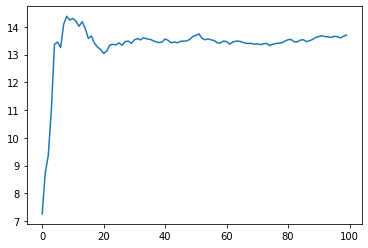

In [339]:
plt.plot(mab_agent_gaussian.overall_expected_reward_list)

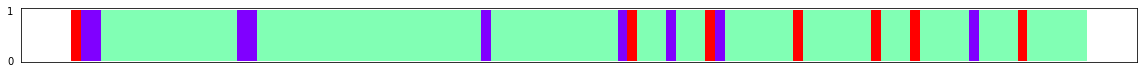

In [340]:
mab_agent_gaussian.plot_sequence()

### Bernoulli Reward

In [341]:
slot_machine_bernoulli = SlotMachine([0.45,0.5,0.1], 'bernoulli')
mab_agent_bernoulli = MAB(n_levers = slot_machine_bernoulli.n_levers, epsilon=0.3, estimation_policy='avg')
mab_agent_bernoulli = run_mab(mab_agent_bernoulli,slot_machine_bernoulli,1000)

In [342]:
print(mab_agent_bernoulli.report)

Lever:'0' Reward:'0.42'
Lever:'1' Reward:'0.56'
Lever:'2' Reward:'0.10'


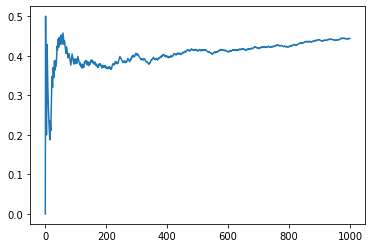

In [335]:
plt.plot(mab_agent_bernoulli.overall_expected_reward_list)

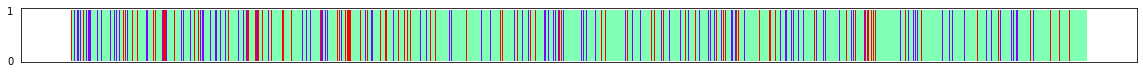

In [336]:
mab_agent_bernoulli.plot_sequence()